# Face Generation

In this project, you'll define and train a DCGAN on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **loading in data to defining and training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset is more complex than the number datasets (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed_celeba_small/`

In [ ]:
# can comment out after executing
!unzip processed_celeba_small.zip

In [2]:
data_dir = 'processed_celeba_small/'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import problem_unittests as tests
#import helper

%matplotlib inline

## Visualize the CelebA Data

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA data.

> There are a few other steps that you'll need to **transform** this data and create a **DataLoader**.

#### Exercise: Complete the following `get_dataloader` function, such that it satisfies these requirements:

* Your images should be square, Tensor images of size `image_size x image_size` in the x and y dimension.
* Your function should return a DataLoader that shuffles and batches these Tensor images.

#### ImageFolder

To create a dataset given a directory of images, it's recommended that you use PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) wrapper, with a root directory `processed_celeba_small/` and data transformation passed in.

In [5]:
# necessary imports
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import os

In [6]:
def get_dataloader(batch_size, image_size, data_dir='processed_celeba_small/'):
    """
    Batch the neural network data using DataLoader
    :param batch_size: The size of each batch; the number of images in a batch
    :param img_size: The square size of the image data (x, y)
    :param data_dir: Directory where image data is located
    :return: DataLoader with batched data
    """
    
    # TODO: Implement function and return a dataloader
    transform = transforms.Compose([transforms.Resize(image_size),
                                   transforms.ToTensor()])
    
    image_path = "./" + data_dir
    data_path = os.path.join(image_path, "celeba")
    
    dataset = datasets.ImageFolder(data_path, transform)
    
    dataloader = DataLoader(dataset=dataset, shuffle=True, batch_size=batch_size)
    
    
    return dataloader


## Create a DataLoader

#### Exercise: Create a DataLoader `celeba_train_loader` with appropriate hyperparameters.

Call the above function and create a dataloader to view images. 
* You can decide on any reasonable `batch_size` parameter
* Your `image_size` **must be** `32`. Resizing the data to a smaller size will make for faster training, while still creating convincing images of faces!

In [11]:
# Define function hyperparameters
batch_size = 20
img_size = 32

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Call your function and get a dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)


Next, you can view some images! You should seen square images of somewhat-centered faces.

Note: You'll need to convert the Tensor images into a NumPy type and transpose the dimensions to correctly display an image, suggested `imshow` code is below, but it may not be perfect.

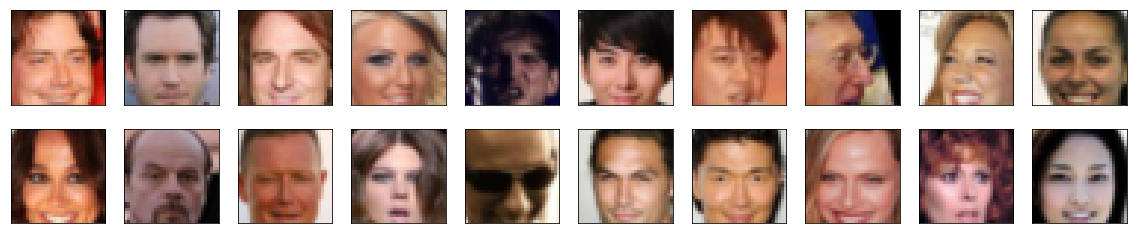

In [12]:
# helper display function
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# obtain one batch of training images
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next() # _ for no labels

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])

#### Exercise: Pre-process your image data and scale it to a pixel range of -1 to 1

You need to do a bit of pre-processing; you know that the output of a `tanh` activated generator will contain pixel values in a range from -1 to 1, and so, we need to rescale our training images to a range of -1 to 1. (Right now, they are in a range from 0-1.)

In [14]:
# TODO: Complete the scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x*(max - min) + min
    return x


In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# check scaled range
# should be close to -1 to 1
img = images[0]
scaled_img = scale(img)

print('Min: ', scaled_img.min())
print('Max: ', scaled_img.max())

Min:  tensor(-0.9922)
Max:  tensor(1.)


---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator.

## Discriminator

Your first task will be to define the discriminator. This is a convolutional classifier like you've built before, only without any maxpooling layers. To deal with this complex data, it's suggested you use a deep network with **normalization**. You are also allowed to create any helper functions that may be useful.

#### Exercise: Complete the Discriminator class
* The inputs to the discriminator are 32x32x3 tensor images
* The output should be a single value that will indicate whether a given image is real or fake


In [21]:
import torch.nn as nn
import torch.nn.functional as F

In [22]:
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers= []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [24]:
class Discriminator(nn.Module):

    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        self.conv1 = conv(3, conv_dim, 4, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: Discriminator logits; the output of the neural network
        """
        # define feedforward behavior
        out = F.leaky_relu(self.conv1(x), 0.2)
        out = F.leaky_relu(self.conv2(out), 0.2)
        out = F.leaky_relu(self.conv3(out), 0.2)
        out = out.view(-1, self.conv_dim*4*4*4)
        out = self.fc(out)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(Discriminator)

Tests Passed


## Generator

The generator should upsample an input and generate a *new* image of the same size as our training data `32x32x3`. This should be mostly transpose convolutional layers with normalization applied to the outputs.

#### Exercise: Complete the Generator class
* The inputs to the generator are vectors of some length `z_size`
* The output should be a image of shape `32x32x3`

In [25]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    layers = []
    trans_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    layers.append(trans_conv_layer)
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

In [31]:
class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: The length of the input latent vector, z
        :param conv_dim: The depth of the inputs to the *last* transpose convolutional layer
        """
        super(Generator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim
        
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)
        
        self.t_conv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.t_conv2 = deconv(conv_dim*2, conv_dim, 4)
        self.t_conv3 = deconv(conv_dim, 3, 4, batch_norm=False)
        
    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network     
        :return: A 32x32x3 Tensor image as output
        """
        # define feedforward behavior
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, width, height)
        out = F.relu(self.t_conv1(out))
        out = F.relu(self.t_conv2(out))
        out = F.tanh(self.t_conv3(out))
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(Generator)

Tests Passed


## Initialize the weights of your networks

To help your models converge, you should initialize the weights of the convolutional and linear layers in your model. From reading the [original DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf), they say:
> All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

So, your next task will be to define a weight initialization function that does just this!

You can refer back to the lesson on weight initialization or even consult existing model code, such as that from [the `networks.py` file in CycleGAN Github repository](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/models/networks.py) to help you complete this function.

#### Exercise: Complete the weight initialization function

* This should initialize only **convolutional** and **linear** layers
* Initialize the weights to a normal distribution, centered around 0, with a standard deviation of 0.02.
* The bias terms, if they exist, may be left alone or set to 0.

In [32]:
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution 
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network    
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__
    
    # TODO: Apply initial weights to convolutional and linear layers
    if classname.find("Linear") != -1:
        """
        n = m.in_features
        y = (1.0/np.sqrt(n))
        """
        m.weight.data.normal_(0, 0.02)
        m.bias.data.fill_(0)

## Build complete network

Define your models' hyperparameters and instantiate the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [41]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
def build_network(d_conv_dim, g_conv_dim, z_size):
    # define discriminator and generator
    D = Discriminator(d_conv_dim)
    G = Generator(z_size=z_size, conv_dim=g_conv_dim)

    # initialize model weights
    D.apply(weights_init_normal)
    G.apply(weights_init_normal)

    print(D)
    print()
    print(G)
    
    return D, G


#### Exercise: Define model hyperparameters

In [46]:
# Define model hyperparams
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (t_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias

### Training on GPU

Check if you can train on GPU. Here, we'll set this as a boolean variable `train_on_gpu`. Later, you'll be responsible for making sure that 
>* Models,
* Model inputs, and
* Loss function arguments

Are moved to GPU, where appropriate.

In [47]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Training on GPU!')
    D = D.cuda()
    G = G.cuda()

Training on GPU!


---
## Discriminator and Generator Losses

Now we need to calculate the losses for both types of adversarial networks.

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.


### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get the discriminator to *think* its generated images are *real*.

#### Exercise: Complete real and fake loss functions

**You may choose to use either cross entropy or a least squares error loss to complete the following `real_loss` and `fake_loss` functions.**

In [48]:
def real_loss(D_out):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    loss = torch.mean((D_out - 1)**2)
    return loss

def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    loss = torch.mean(D_out**2)
    return loss

## Optimizers

#### Exercise: Define optimizers for your Discriminator (D) and Generator (G)

Define optimizers for your models with appropriate hyperparameters.

In [49]:
import torch.optim as optim

# Create optimizers for the discriminator D and generator G
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

---
## Training

Training will involve alternating between training the discriminator and the generator. You'll use your functions `real_loss` and `fake_loss` to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function


#### Saving Samples

You've been given some code to print out some loss statistics and save some generated "fake" samples.

#### Exercise: Complete the training function

Keep in mind that, if you've moved your models to GPU, you'll also have to move any model inputs to GPU.

In [52]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''
    
    # move models to GPU
    if train_on_gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=16
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if train_on_gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale(real_images)

            if train_on_gpu:
                real_images = real_images.cuda()
            # ===============================================
            #         YOUR CODE HERE: TRAIN THE NETWORKS
            # ===============================================
            
            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()
            
            D_real = D(real_images)
            d_real_loss = real_loss(D_real)
            
            #train with fake images
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            
            #compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)
            
            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()
            
            
            
            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()
            
            # train with fake images and flipped labels
            #generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if train_on_gpu:
                z = z.cuda()
            fake_images = G(z)
            # compute the discriminator losses on fake images
            # using flipped labels:
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels
            #perform backpropagation
            g_loss.backward()
            g_optimizer.step()
            
            
            # ===============================================
            #              END OF YOUR CODE
            # ===============================================

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))


        ## AFTER EACH EPOCH##    
        # this code assumes your generator is named G, feel free to change the name
        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    # finally return losses
    return losses

Set your number of training epochs and train your GAN!

In [53]:
# set number of epochs 
n_epochs = 50


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# call training function
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 2.4023 | g_loss: 1.0679
Epoch [    1/   50] | d_loss: 0.1388 | g_loss: 1.2555
Epoch [    1/   50] | d_loss: 0.0680 | g_loss: 1.1053
Epoch [    1/   50] | d_loss: 0.0733 | g_loss: 1.1141
Epoch [    1/   50] | d_loss: 0.0374 | g_loss: 0.7969
Epoch [    1/   50] | d_loss: 0.1070 | g_loss: 0.5904
Epoch [    1/   50] | d_loss: 0.1618 | g_loss: 0.5382
Epoch [    1/   50] | d_loss: 0.1153 | g_loss: 0.7743
Epoch [    1/   50] | d_loss: 0.0995 | g_loss: 0.8176
Epoch [    1/   50] | d_loss: 0.0843 | g_loss: 0.8500
Epoch [    1/   50] | d_loss: 0.1490 | g_loss: 1.4713
Epoch [    1/   50] | d_loss: 0.1297 | g_loss: 0.7026
Epoch [    1/   50] | d_loss: 0.1964 | g_loss: 0.5407
Epoch [    1/   50] | d_loss: 0.1584 | g_loss: 0.5573
Epoch [    1/   50] | d_loss: 0.1135 | g_loss: 0.7827
Epoch [    1/   50] | d_loss: 0.2172 | g_loss: 0.4394
Epoch [    1/   50] | d_loss: 0.1845 | g_loss: 0.8291
Epoch [    1/   50] | d_loss: 0.1320 | g_loss: 1.2025
Epoch [    1/   50] | d_loss

Epoch [    3/   50] | d_loss: 0.1936 | g_loss: 0.6193
Epoch [    3/   50] | d_loss: 0.4724 | g_loss: 0.2841
Epoch [    3/   50] | d_loss: 0.2755 | g_loss: 0.6753
Epoch [    3/   50] | d_loss: 0.2563 | g_loss: 0.7571
Epoch [    3/   50] | d_loss: 0.2251 | g_loss: 0.5934
Epoch [    3/   50] | d_loss: 0.2555 | g_loss: 0.6642
Epoch [    3/   50] | d_loss: 0.3798 | g_loss: 0.5468
Epoch [    3/   50] | d_loss: 0.4951 | g_loss: 0.4418
Epoch [    3/   50] | d_loss: 0.3247 | g_loss: 0.3587
Epoch [    3/   50] | d_loss: 0.3136 | g_loss: 0.4209
Epoch [    3/   50] | d_loss: 0.4819 | g_loss: 0.6338
Epoch [    3/   50] | d_loss: 0.2293 | g_loss: 0.7440
Epoch [    3/   50] | d_loss: 0.1610 | g_loss: 0.6026
Epoch [    3/   50] | d_loss: 0.1208 | g_loss: 0.7479
Epoch [    3/   50] | d_loss: 0.3363 | g_loss: 0.4610
Epoch [    3/   50] | d_loss: 0.3639 | g_loss: 0.6069
Epoch [    3/   50] | d_loss: 0.2127 | g_loss: 0.6696
Epoch [    3/   50] | d_loss: 0.6588 | g_loss: 0.4707
Epoch [    3/   50] | d_loss

Epoch [    6/   50] | d_loss: 0.2365 | g_loss: 0.6218
Epoch [    6/   50] | d_loss: 0.2691 | g_loss: 0.3606
Epoch [    6/   50] | d_loss: 0.1478 | g_loss: 0.6227
Epoch [    6/   50] | d_loss: 0.2040 | g_loss: 1.0142
Epoch [    6/   50] | d_loss: 0.1976 | g_loss: 0.7627
Epoch [    6/   50] | d_loss: 0.1601 | g_loss: 0.5807
Epoch [    6/   50] | d_loss: 0.3370 | g_loss: 0.6770
Epoch [    6/   50] | d_loss: 0.2200 | g_loss: 0.6233
Epoch [    6/   50] | d_loss: 0.2005 | g_loss: 0.4244
Epoch [    6/   50] | d_loss: 0.1295 | g_loss: 0.6922
Epoch [    6/   50] | d_loss: 0.2241 | g_loss: 0.7862
Epoch [    6/   50] | d_loss: 0.2473 | g_loss: 0.4971
Epoch [    6/   50] | d_loss: 0.5434 | g_loss: 0.4575
Epoch [    6/   50] | d_loss: 0.2399 | g_loss: 0.5474
Epoch [    6/   50] | d_loss: 0.3007 | g_loss: 0.8462
Epoch [    6/   50] | d_loss: 0.2629 | g_loss: 0.5796
Epoch [    6/   50] | d_loss: 0.4020 | g_loss: 0.6317
Epoch [    6/   50] | d_loss: 0.3083 | g_loss: 0.4405
Epoch [    6/   50] | d_loss

Epoch [    8/   50] | d_loss: 0.2432 | g_loss: 0.7215
Epoch [    8/   50] | d_loss: 0.1600 | g_loss: 0.5014
Epoch [    8/   50] | d_loss: 0.1364 | g_loss: 0.8400
Epoch [    8/   50] | d_loss: 0.1948 | g_loss: 0.8579
Epoch [    8/   50] | d_loss: 0.2779 | g_loss: 0.5346
Epoch [    8/   50] | d_loss: 0.2104 | g_loss: 0.6283
Epoch [    8/   50] | d_loss: 0.1841 | g_loss: 0.5698
Epoch [    8/   50] | d_loss: 0.3329 | g_loss: 0.6325
Epoch [    9/   50] | d_loss: 0.2601 | g_loss: 0.6582
Epoch [    9/   50] | d_loss: 0.3066 | g_loss: 0.5512
Epoch [    9/   50] | d_loss: 0.1391 | g_loss: 1.0850
Epoch [    9/   50] | d_loss: 0.1655 | g_loss: 0.7570
Epoch [    9/   50] | d_loss: 0.2973 | g_loss: 0.7127
Epoch [    9/   50] | d_loss: 0.1795 | g_loss: 0.3790
Epoch [    9/   50] | d_loss: 0.2531 | g_loss: 0.8481
Epoch [    9/   50] | d_loss: 0.1448 | g_loss: 0.5962
Epoch [    9/   50] | d_loss: 0.2677 | g_loss: 0.4367
Epoch [    9/   50] | d_loss: 0.2013 | g_loss: 0.4954
Epoch [    9/   50] | d_loss

Epoch [   11/   50] | d_loss: 0.1961 | g_loss: 0.6844
Epoch [   11/   50] | d_loss: 0.1778 | g_loss: 0.6535
Epoch [   11/   50] | d_loss: 0.1177 | g_loss: 0.8958
Epoch [   11/   50] | d_loss: 0.2015 | g_loss: 0.5622
Epoch [   11/   50] | d_loss: 0.2477 | g_loss: 0.6826
Epoch [   11/   50] | d_loss: 0.1736 | g_loss: 0.7930
Epoch [   11/   50] | d_loss: 0.1420 | g_loss: 1.2023
Epoch [   11/   50] | d_loss: 0.2774 | g_loss: 0.4007
Epoch [   11/   50] | d_loss: 0.3855 | g_loss: 0.4315
Epoch [   11/   50] | d_loss: 0.2787 | g_loss: 1.0616
Epoch [   11/   50] | d_loss: 0.1408 | g_loss: 0.9400
Epoch [   11/   50] | d_loss: 0.2132 | g_loss: 0.6490
Epoch [   11/   50] | d_loss: 0.1757 | g_loss: 0.4786
Epoch [   11/   50] | d_loss: 0.2052 | g_loss: 0.4608
Epoch [   11/   50] | d_loss: 0.1850 | g_loss: 0.4881
Epoch [   11/   50] | d_loss: 0.2147 | g_loss: 0.3470
Epoch [   11/   50] | d_loss: 0.1541 | g_loss: 0.8559
Epoch [   11/   50] | d_loss: 0.3087 | g_loss: 0.5990
Epoch [   11/   50] | d_loss

Epoch [   14/   50] | d_loss: 0.0975 | g_loss: 0.6727
Epoch [   14/   50] | d_loss: 0.2167 | g_loss: 0.6296
Epoch [   14/   50] | d_loss: 0.2197 | g_loss: 0.9972
Epoch [   14/   50] | d_loss: 0.3276 | g_loss: 0.5343
Epoch [   14/   50] | d_loss: 0.0897 | g_loss: 1.2938
Epoch [   14/   50] | d_loss: 0.1015 | g_loss: 1.0068
Epoch [   14/   50] | d_loss: 0.3319 | g_loss: 0.7552
Epoch [   14/   50] | d_loss: 0.1193 | g_loss: 0.6930
Epoch [   14/   50] | d_loss: 0.2730 | g_loss: 0.3422
Epoch [   14/   50] | d_loss: 0.1968 | g_loss: 1.0794
Epoch [   14/   50] | d_loss: 0.2066 | g_loss: 0.6111
Epoch [   14/   50] | d_loss: 0.2098 | g_loss: 0.8117
Epoch [   14/   50] | d_loss: 0.1120 | g_loss: 0.7425
Epoch [   14/   50] | d_loss: 0.1278 | g_loss: 0.5347
Epoch [   14/   50] | d_loss: 0.2027 | g_loss: 0.6659
Epoch [   14/   50] | d_loss: 0.1222 | g_loss: 1.0555
Epoch [   14/   50] | d_loss: 0.2387 | g_loss: 0.6635
Epoch [   14/   50] | d_loss: 0.2860 | g_loss: 1.2653
Epoch [   14/   50] | d_loss

Epoch [   16/   50] | d_loss: 0.1459 | g_loss: 0.7862
Epoch [   16/   50] | d_loss: 0.1046 | g_loss: 0.8691
Epoch [   16/   50] | d_loss: 0.1888 | g_loss: 0.8639
Epoch [   16/   50] | d_loss: 0.3240 | g_loss: 0.5159
Epoch [   16/   50] | d_loss: 0.0738 | g_loss: 0.6668
Epoch [   16/   50] | d_loss: 0.0915 | g_loss: 0.4564
Epoch [   16/   50] | d_loss: 0.2664 | g_loss: 0.6245
Epoch [   16/   50] | d_loss: 0.2251 | g_loss: 0.6610
Epoch [   16/   50] | d_loss: 0.1610 | g_loss: 0.8345
Epoch [   16/   50] | d_loss: 0.1477 | g_loss: 0.6612
Epoch [   16/   50] | d_loss: 0.1340 | g_loss: 0.4550
Epoch [   16/   50] | d_loss: 0.2960 | g_loss: 0.4333
Epoch [   16/   50] | d_loss: 0.1907 | g_loss: 1.0167
Epoch [   16/   50] | d_loss: 0.1557 | g_loss: 1.0011
Epoch [   16/   50] | d_loss: 0.2584 | g_loss: 0.3934
Epoch [   16/   50] | d_loss: 0.4052 | g_loss: 1.3202
Epoch [   17/   50] | d_loss: 0.1011 | g_loss: 0.4796
Epoch [   17/   50] | d_loss: 0.2743 | g_loss: 0.3945
Epoch [   17/   50] | d_loss

Epoch [   19/   50] | d_loss: 0.1610 | g_loss: 1.0657
Epoch [   19/   50] | d_loss: 0.0958 | g_loss: 0.7998
Epoch [   19/   50] | d_loss: 0.3190 | g_loss: 0.9573
Epoch [   19/   50] | d_loss: 0.1127 | g_loss: 0.5574
Epoch [   19/   50] | d_loss: 0.2280 | g_loss: 0.5382
Epoch [   19/   50] | d_loss: 0.1421 | g_loss: 0.6009
Epoch [   19/   50] | d_loss: 0.1362 | g_loss: 0.4933
Epoch [   19/   50] | d_loss: 0.1187 | g_loss: 0.4354
Epoch [   19/   50] | d_loss: 0.1484 | g_loss: 0.5195
Epoch [   19/   50] | d_loss: 0.0902 | g_loss: 0.4507
Epoch [   19/   50] | d_loss: 0.1856 | g_loss: 0.7652
Epoch [   19/   50] | d_loss: 0.0885 | g_loss: 0.8464
Epoch [   19/   50] | d_loss: 0.1465 | g_loss: 0.3334
Epoch [   19/   50] | d_loss: 0.1383 | g_loss: 0.4999
Epoch [   19/   50] | d_loss: 0.2511 | g_loss: 0.1254
Epoch [   19/   50] | d_loss: 0.0484 | g_loss: 1.0294
Epoch [   19/   50] | d_loss: 0.1562 | g_loss: 0.4391
Epoch [   19/   50] | d_loss: 0.0900 | g_loss: 0.9776
Epoch [   19/   50] | d_loss

Epoch [   21/   50] | d_loss: 0.1523 | g_loss: 0.4307
Epoch [   21/   50] | d_loss: 0.1599 | g_loss: 0.6149
Epoch [   22/   50] | d_loss: 0.0663 | g_loss: 0.8794
Epoch [   22/   50] | d_loss: 0.3482 | g_loss: 0.4905
Epoch [   22/   50] | d_loss: 0.0831 | g_loss: 0.9499
Epoch [   22/   50] | d_loss: 0.1535 | g_loss: 0.8253
Epoch [   22/   50] | d_loss: 0.0704 | g_loss: 0.5059
Epoch [   22/   50] | d_loss: 0.1603 | g_loss: 0.5401
Epoch [   22/   50] | d_loss: 0.0926 | g_loss: 0.6385
Epoch [   22/   50] | d_loss: 0.2610 | g_loss: 0.8929
Epoch [   22/   50] | d_loss: 0.1327 | g_loss: 0.5502
Epoch [   22/   50] | d_loss: 0.0576 | g_loss: 0.7796
Epoch [   22/   50] | d_loss: 0.4035 | g_loss: 0.7009
Epoch [   22/   50] | d_loss: 0.2002 | g_loss: 0.9294
Epoch [   22/   50] | d_loss: 0.2547 | g_loss: 0.3699
Epoch [   22/   50] | d_loss: 0.1247 | g_loss: 0.6329
Epoch [   22/   50] | d_loss: 0.1694 | g_loss: 0.7232
Epoch [   22/   50] | d_loss: 0.1861 | g_loss: 1.2737
Epoch [   22/   50] | d_loss

Epoch [   24/   50] | d_loss: 0.0837 | g_loss: 0.6524
Epoch [   24/   50] | d_loss: 0.1376 | g_loss: 0.5381
Epoch [   24/   50] | d_loss: 0.1101 | g_loss: 0.7911
Epoch [   24/   50] | d_loss: 0.0806 | g_loss: 0.7336
Epoch [   24/   50] | d_loss: 0.0712 | g_loss: 1.0154
Epoch [   24/   50] | d_loss: 0.1175 | g_loss: 0.5616
Epoch [   24/   50] | d_loss: 0.0828 | g_loss: 0.9079
Epoch [   24/   50] | d_loss: 0.1352 | g_loss: 0.6941
Epoch [   24/   50] | d_loss: 0.1405 | g_loss: 0.3656
Epoch [   24/   50] | d_loss: 0.1007 | g_loss: 0.6574
Epoch [   24/   50] | d_loss: 0.0721 | g_loss: 0.7873
Epoch [   24/   50] | d_loss: 0.1331 | g_loss: 0.9389
Epoch [   24/   50] | d_loss: 0.1186 | g_loss: 1.0378
Epoch [   24/   50] | d_loss: 0.1258 | g_loss: 0.8600
Epoch [   24/   50] | d_loss: 0.0650 | g_loss: 1.3524
Epoch [   24/   50] | d_loss: 0.1095 | g_loss: 0.8860
Epoch [   24/   50] | d_loss: 0.0829 | g_loss: 0.8615
Epoch [   24/   50] | d_loss: 0.1689 | g_loss: 1.0544
Epoch [   24/   50] | d_loss

Epoch [   27/   50] | d_loss: 0.2000 | g_loss: 0.5330
Epoch [   27/   50] | d_loss: 0.1092 | g_loss: 1.0019
Epoch [   27/   50] | d_loss: 0.0806 | g_loss: 1.0998
Epoch [   27/   50] | d_loss: 0.2396 | g_loss: 0.6450
Epoch [   27/   50] | d_loss: 0.1167 | g_loss: 1.0126
Epoch [   27/   50] | d_loss: 0.0726 | g_loss: 0.9535
Epoch [   27/   50] | d_loss: 0.1174 | g_loss: 0.5970
Epoch [   27/   50] | d_loss: 0.0779 | g_loss: 0.9809
Epoch [   27/   50] | d_loss: 0.2129 | g_loss: 0.4843
Epoch [   27/   50] | d_loss: 0.1265 | g_loss: 0.6168
Epoch [   27/   50] | d_loss: 0.1184 | g_loss: 0.7429
Epoch [   27/   50] | d_loss: 0.1513 | g_loss: 0.9227
Epoch [   27/   50] | d_loss: 0.1398 | g_loss: 0.3717
Epoch [   27/   50] | d_loss: 0.0783 | g_loss: 1.0741
Epoch [   27/   50] | d_loss: 0.1059 | g_loss: 1.5245
Epoch [   27/   50] | d_loss: 0.1639 | g_loss: 0.6614
Epoch [   27/   50] | d_loss: 0.0921 | g_loss: 0.6577
Epoch [   27/   50] | d_loss: 0.0769 | g_loss: 0.9758
Epoch [   27/   50] | d_loss

Epoch [   29/   50] | d_loss: 0.0897 | g_loss: 0.8586
Epoch [   29/   50] | d_loss: 0.0656 | g_loss: 0.8935
Epoch [   29/   50] | d_loss: 0.1833 | g_loss: 1.1157
Epoch [   29/   50] | d_loss: 0.2186 | g_loss: 0.6967
Epoch [   29/   50] | d_loss: 0.1828 | g_loss: 0.5478
Epoch [   29/   50] | d_loss: 0.0486 | g_loss: 1.4022
Epoch [   29/   50] | d_loss: 0.1362 | g_loss: 0.8145
Epoch [   29/   50] | d_loss: 0.0695 | g_loss: 0.8915
Epoch [   29/   50] | d_loss: 0.1636 | g_loss: 0.4743
Epoch [   29/   50] | d_loss: 0.1235 | g_loss: 1.0149
Epoch [   30/   50] | d_loss: 0.0932 | g_loss: 0.9208
Epoch [   30/   50] | d_loss: 0.1638 | g_loss: 0.7368
Epoch [   30/   50] | d_loss: 0.1381 | g_loss: 1.0164
Epoch [   30/   50] | d_loss: 0.3526 | g_loss: 0.6658
Epoch [   30/   50] | d_loss: 0.1032 | g_loss: 0.5184
Epoch [   30/   50] | d_loss: 0.0968 | g_loss: 0.8348
Epoch [   30/   50] | d_loss: 0.1264 | g_loss: 1.2678
Epoch [   30/   50] | d_loss: 0.1476 | g_loss: 0.7942
Epoch [   30/   50] | d_loss

Epoch [   32/   50] | d_loss: 0.1034 | g_loss: 0.9752
Epoch [   32/   50] | d_loss: 0.0471 | g_loss: 1.0051
Epoch [   32/   50] | d_loss: 0.1880 | g_loss: 0.7169
Epoch [   32/   50] | d_loss: 0.1841 | g_loss: 0.8489
Epoch [   32/   50] | d_loss: 0.0502 | g_loss: 0.7053
Epoch [   32/   50] | d_loss: 0.0475 | g_loss: 1.0449
Epoch [   32/   50] | d_loss: 0.2760 | g_loss: 0.6527
Epoch [   32/   50] | d_loss: 0.1282 | g_loss: 0.8985
Epoch [   32/   50] | d_loss: 0.0863 | g_loss: 0.7799
Epoch [   32/   50] | d_loss: 0.1256 | g_loss: 0.7474
Epoch [   32/   50] | d_loss: 0.0777 | g_loss: 0.4337
Epoch [   32/   50] | d_loss: 0.0699 | g_loss: 1.2979
Epoch [   32/   50] | d_loss: 0.0422 | g_loss: 0.9159
Epoch [   32/   50] | d_loss: 0.1099 | g_loss: 0.7364
Epoch [   32/   50] | d_loss: 0.1355 | g_loss: 0.6777
Epoch [   32/   50] | d_loss: 0.0902 | g_loss: 0.7862
Epoch [   32/   50] | d_loss: 0.0825 | g_loss: 0.7375
Epoch [   32/   50] | d_loss: 0.1032 | g_loss: 0.8621
Epoch [   32/   50] | d_loss

Epoch [   35/   50] | d_loss: 0.1560 | g_loss: 0.9949
Epoch [   35/   50] | d_loss: 0.0485 | g_loss: 1.3441
Epoch [   35/   50] | d_loss: 0.1030 | g_loss: 1.0450
Epoch [   35/   50] | d_loss: 0.1094 | g_loss: 0.7026
Epoch [   35/   50] | d_loss: 0.0737 | g_loss: 1.0314
Epoch [   35/   50] | d_loss: 0.1336 | g_loss: 0.6092
Epoch [   35/   50] | d_loss: 0.2107 | g_loss: 0.7541
Epoch [   35/   50] | d_loss: 0.0666 | g_loss: 0.9999
Epoch [   35/   50] | d_loss: 0.0682 | g_loss: 1.3039
Epoch [   35/   50] | d_loss: 0.0669 | g_loss: 0.7117
Epoch [   35/   50] | d_loss: 0.0891 | g_loss: 1.2056
Epoch [   35/   50] | d_loss: 0.0395 | g_loss: 0.8397
Epoch [   35/   50] | d_loss: 0.0331 | g_loss: 0.5249
Epoch [   35/   50] | d_loss: 0.1722 | g_loss: 0.6722
Epoch [   35/   50] | d_loss: 0.0993 | g_loss: 0.6578
Epoch [   35/   50] | d_loss: 0.0855 | g_loss: 1.3345
Epoch [   35/   50] | d_loss: 0.0653 | g_loss: 0.9529
Epoch [   35/   50] | d_loss: 0.0960 | g_loss: 0.7153
Epoch [   35/   50] | d_loss

Epoch [   37/   50] | d_loss: 0.1595 | g_loss: 0.7762
Epoch [   37/   50] | d_loss: 0.1354 | g_loss: 0.8462
Epoch [   37/   50] | d_loss: 0.0604 | g_loss: 1.0707
Epoch [   37/   50] | d_loss: 0.1377 | g_loss: 0.8354
Epoch [   37/   50] | d_loss: 0.1238 | g_loss: 0.7935
Epoch [   37/   50] | d_loss: 0.0631 | g_loss: 0.9199
Epoch [   37/   50] | d_loss: 0.1406 | g_loss: 1.0138
Epoch [   37/   50] | d_loss: 0.0514 | g_loss: 0.9500
Epoch [   37/   50] | d_loss: 0.0662 | g_loss: 1.0310
Epoch [   37/   50] | d_loss: 0.2243 | g_loss: 0.6996
Epoch [   37/   50] | d_loss: 0.1668 | g_loss: 0.4651
Epoch [   37/   50] | d_loss: 0.0669 | g_loss: 0.7103
Epoch [   37/   50] | d_loss: 0.1265 | g_loss: 0.6009
Epoch [   37/   50] | d_loss: 0.1079 | g_loss: 0.9718
Epoch [   37/   50] | d_loss: 0.1033 | g_loss: 0.7232
Epoch [   37/   50] | d_loss: 0.1143 | g_loss: 0.6749
Epoch [   37/   50] | d_loss: 0.1719 | g_loss: 0.7495
Epoch [   37/   50] | d_loss: 0.0710 | g_loss: 1.2713
Epoch [   38/   50] | d_loss

Epoch [   40/   50] | d_loss: 0.2495 | g_loss: 1.1225
Epoch [   40/   50] | d_loss: 0.0420 | g_loss: 1.0459
Epoch [   40/   50] | d_loss: 0.1214 | g_loss: 0.7984
Epoch [   40/   50] | d_loss: 0.0394 | g_loss: 0.8054
Epoch [   40/   50] | d_loss: 0.1578 | g_loss: 0.5573
Epoch [   40/   50] | d_loss: 0.0572 | g_loss: 0.9042
Epoch [   40/   50] | d_loss: 0.0539 | g_loss: 1.2849
Epoch [   40/   50] | d_loss: 0.1361 | g_loss: 0.7880
Epoch [   40/   50] | d_loss: 0.0515 | g_loss: 0.8355
Epoch [   40/   50] | d_loss: 0.1608 | g_loss: 0.5753
Epoch [   40/   50] | d_loss: 0.1423 | g_loss: 0.7832
Epoch [   40/   50] | d_loss: 0.1087 | g_loss: 0.6033
Epoch [   40/   50] | d_loss: 0.1738 | g_loss: 0.6561
Epoch [   40/   50] | d_loss: 0.0675 | g_loss: 1.2268
Epoch [   40/   50] | d_loss: 0.1342 | g_loss: 1.1304
Epoch [   40/   50] | d_loss: 0.1402 | g_loss: 0.5145
Epoch [   40/   50] | d_loss: 0.0412 | g_loss: 0.6465
Epoch [   40/   50] | d_loss: 0.0666 | g_loss: 1.1697
Epoch [   40/   50] | d_loss

Epoch [   42/   50] | d_loss: 0.0827 | g_loss: 0.6431
Epoch [   42/   50] | d_loss: 0.1461 | g_loss: 0.7770
Epoch [   42/   50] | d_loss: 0.1357 | g_loss: 0.7560
Epoch [   42/   50] | d_loss: 0.1217 | g_loss: 1.1751
Epoch [   43/   50] | d_loss: 0.0574 | g_loss: 0.6074
Epoch [   43/   50] | d_loss: 0.1140 | g_loss: 0.9503
Epoch [   43/   50] | d_loss: 0.1121 | g_loss: 1.1892
Epoch [   43/   50] | d_loss: 0.2095 | g_loss: 0.7243
Epoch [   43/   50] | d_loss: 0.1019 | g_loss: 0.7258
Epoch [   43/   50] | d_loss: 0.1713 | g_loss: 0.9329
Epoch [   43/   50] | d_loss: 0.1026 | g_loss: 0.7191
Epoch [   43/   50] | d_loss: 0.2825 | g_loss: 1.2507
Epoch [   43/   50] | d_loss: 0.0674 | g_loss: 1.0525
Epoch [   43/   50] | d_loss: 0.1683 | g_loss: 0.7189
Epoch [   43/   50] | d_loss: 0.0381 | g_loss: 0.7269
Epoch [   43/   50] | d_loss: 0.0925 | g_loss: 0.6826
Epoch [   43/   50] | d_loss: 0.1098 | g_loss: 1.1155
Epoch [   43/   50] | d_loss: 0.0946 | g_loss: 0.8919
Epoch [   43/   50] | d_loss

Epoch [   45/   50] | d_loss: 0.0811 | g_loss: 1.0107
Epoch [   45/   50] | d_loss: 0.1353 | g_loss: 0.4761
Epoch [   45/   50] | d_loss: 0.0518 | g_loss: 1.1441
Epoch [   45/   50] | d_loss: 0.1322 | g_loss: 0.7841
Epoch [   45/   50] | d_loss: 0.2007 | g_loss: 0.6538
Epoch [   45/   50] | d_loss: 0.0563 | g_loss: 1.0904
Epoch [   45/   50] | d_loss: 0.1549 | g_loss: 0.5430
Epoch [   45/   50] | d_loss: 0.1080 | g_loss: 0.7101
Epoch [   45/   50] | d_loss: 0.1081 | g_loss: 1.3756
Epoch [   45/   50] | d_loss: 0.0447 | g_loss: 0.9081
Epoch [   45/   50] | d_loss: 0.0698 | g_loss: 1.0082
Epoch [   45/   50] | d_loss: 0.0456 | g_loss: 0.7927
Epoch [   45/   50] | d_loss: 0.0985 | g_loss: 0.7136
Epoch [   45/   50] | d_loss: 0.1290 | g_loss: 1.1819
Epoch [   45/   50] | d_loss: 0.0845 | g_loss: 1.0600
Epoch [   45/   50] | d_loss: 0.1014 | g_loss: 0.9276
Epoch [   45/   50] | d_loss: 0.1991 | g_loss: 0.9973
Epoch [   45/   50] | d_loss: 0.0630 | g_loss: 1.1598
Epoch [   45/   50] | d_loss

Epoch [   48/   50] | d_loss: 0.0785 | g_loss: 0.9540
Epoch [   48/   50] | d_loss: 0.1364 | g_loss: 0.9046
Epoch [   48/   50] | d_loss: 0.1917 | g_loss: 0.6244
Epoch [   48/   50] | d_loss: 0.0779 | g_loss: 0.7290
Epoch [   48/   50] | d_loss: 0.1142 | g_loss: 0.8131
Epoch [   48/   50] | d_loss: 0.2365 | g_loss: 0.6239
Epoch [   48/   50] | d_loss: 0.1009 | g_loss: 1.1285
Epoch [   48/   50] | d_loss: 0.0685 | g_loss: 1.1198
Epoch [   48/   50] | d_loss: 0.0449 | g_loss: 1.0155
Epoch [   48/   50] | d_loss: 0.0902 | g_loss: 0.7764
Epoch [   48/   50] | d_loss: 0.0629 | g_loss: 0.6503
Epoch [   48/   50] | d_loss: 0.1840 | g_loss: 0.6542
Epoch [   48/   50] | d_loss: 0.1782 | g_loss: 0.7463
Epoch [   48/   50] | d_loss: 0.1042 | g_loss: 0.9288
Epoch [   48/   50] | d_loss: 0.0244 | g_loss: 1.0201
Epoch [   48/   50] | d_loss: 0.1153 | g_loss: 0.4458
Epoch [   48/   50] | d_loss: 0.1805 | g_loss: 0.6536
Epoch [   48/   50] | d_loss: 0.1176 | g_loss: 0.7756
Epoch [   48/   50] | d_loss

Epoch [   50/   50] | d_loss: 0.0583 | g_loss: 0.8557
Epoch [   50/   50] | d_loss: 0.1566 | g_loss: 1.1538
Epoch [   50/   50] | d_loss: 0.0868 | g_loss: 0.4125
Epoch [   50/   50] | d_loss: 0.0671 | g_loss: 0.9790
Epoch [   50/   50] | d_loss: 0.0669 | g_loss: 0.9027
Epoch [   50/   50] | d_loss: 0.0492 | g_loss: 0.3770
Epoch [   50/   50] | d_loss: 0.2740 | g_loss: 0.6346
Epoch [   50/   50] | d_loss: 0.1291 | g_loss: 0.7632
Epoch [   50/   50] | d_loss: 0.0425 | g_loss: 0.8858
Epoch [   50/   50] | d_loss: 0.1401 | g_loss: 1.0605
Epoch [   50/   50] | d_loss: 0.0703 | g_loss: 0.6565
Epoch [   50/   50] | d_loss: 0.0409 | g_loss: 1.0990


## Training loss

Plot the training losses for the generator and discriminator, recorded after each epoch.

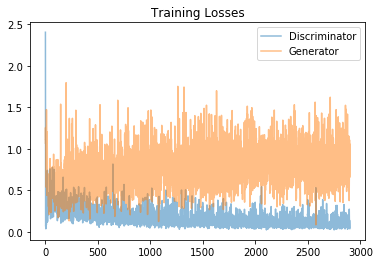

In [54]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## Generator samples from training

View samples of images from the generator, and answer a question about the strengths and weaknesses of your trained models.

In [55]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [56]:
# Load samples from generator, taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

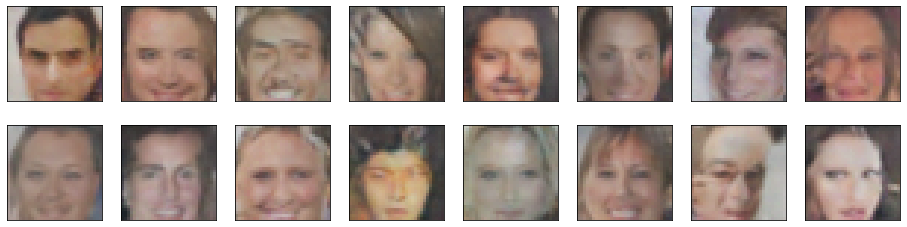

In [57]:
_ = view_samples(-1, samples)

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result


**Answer:** (Write your answer in this cell)


The images generated looks blurry with some deformations in the borders of the face. However, it is perceptible the human face.

* As the dataset is biased, we won't find generated faces for black people, because the model won't learn those kind of faces due to the lack of those kind of images in dataset. So, in order to avoid this problem we should add more images for people around the world.

* We tested with 3 layers in the Discriminator and 3 layers in Generator and the results looks good. However, we can try increasing those layers.

* We tested with the following optimization hyperparameters:
>lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_epochs = 50
batch_size = 20

* We also tested with the following model hyperparameters:
>Number of layers (Discriminator Network) = 3
Number of layers (Generator Network) = 3


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "problem_unittests.py" files in your submission.